In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
# from torchviz import make_dot

from cifar10_models_qinacme import model1, model3, model2, model_torch_official
%load_ext autoreload
%autoreload 2

In [2]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, 
                                       transform=transform)

valid_size = int(len(trainset) * 0.1)
indices = list(range(0, len(trainset)))
np.random.seed()
np.random.shuffle(indices)
train_idx = indices[valid_size:]
valid_idx = indices[:valid_size]


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(train_idx), num_workers=2)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(valid_idx), num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                      transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False,
                                         num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
NUM_INCREASE = 3
def train(model, epoch_num=30):
    results = []
    model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
#     optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    print_freq = 60
    for epoch in range(epoch_num):
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
        
        
        r = collect_data(model, criterion)
        print('[Epoch {:<2}]: \ntrain_acc  {} \ntrain_loss {} \nvalid_acc  {} \nvalid_loss {} \ntest_acc    {} \ntest_loss  {}'
              .format(epoch, *r))
        results.append(r)
        valid_loss = np.array(results)[:,3]
        
#         if epoch > NUM_INCREASE and np.all(np.diff(valid_loss[epoch - NUM_INCREASE + 1 : epoch + 1]) > 0):
#             print('Early stop at Epoch {}'.format(epoch+1))
#             break
    print('Finished Training')
    return results

In [4]:
def collect_data(model, criterion):
    result = []
    for loader in [trainloader, validloader, testloader]:
        correct = 0
        total = 0
        loss = 0.
        for data in loader:
            images, labels = data
            outputs = model(Variable(images.cuda()))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.cuda()).sum()
            loss += criterion(outputs, Variable(labels.cuda())).data[0]
        result.append(correct / total) # accuracy
        result.append(loss / total) # loss
    return result

In [5]:
def test(model):
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = model(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()
        
    print('Accuracy of the network on the 10000 test images: {:0.2f}%'
          .format(100 * correct / total))
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    for data in testloader:
        images, labels = data
        outputs = model(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels.cuda())
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    for i in range(10):
        print('Accuracy of {:<5} : {:0.2f}%'
              .format(classes[i], 100*class_correct[i]/class_total[i]))
    

In [6]:
def visualize(model, results):
    results = np.array(results)
    for i in [0,2,4]:
        plt.plot(np.arange(results.shape[0]), results[:,i])
    plt.legend(['train acc', 'vald acc', 'test acc'], loc='upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy - Epoch')
    plt.show()
    for i in [1,3,5]:
        plt.plot(np.arange(results.shape[0]), results[:,i])
    plt.legend(['train loss','vald loss', 'test loss'], loc='upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss - Epoch')
    plt.show()

# Original PyTorch tutorial model

In [7]:
net = model_torch_official()

In [8]:
results = train(net)

[Epoch 0 ]: 
train_acc  0.46142222222222223 
train_loss 0.011595499163203769 
valid_acc  0.4516 
valid_loss 0.011755787312984467 
test_acc    0.4562 
test_loss  0.011730286705493927
[Epoch 1 ]: 
train_acc  0.5168222222222222 
train_loss 0.010510918161604139 
valid_acc  0.5062 
valid_loss 0.011005263924598694 
test_acc    0.5076 
test_loss  0.010769358801841735
[Epoch 2 ]: 
train_acc  0.5638 
train_loss 0.009538577817545997 
valid_acc  0.5542 
valid_loss 0.009969540786743164 
test_acc    0.5533 
test_loss  0.009866367292404175
[Epoch 3 ]: 
train_acc  0.5889111111111112 
train_loss 0.009099510622024536 
valid_acc  0.5766 
valid_loss 0.009507305407524109 
test_acc    0.5754 
test_loss  0.00957777596116066
[Epoch 4 ]: 
train_acc  0.6224666666666666 
train_loss 0.008338003669844734 
valid_acc  0.6074 
valid_loss 0.009032354354858399 
test_acc    0.5991 
test_loss  0.008973217606544494
[Epoch 5 ]: 
train_acc  0.6324888888888889 
train_loss 0.008157504916191102 
valid_acc  0.612 
valid_loss 0

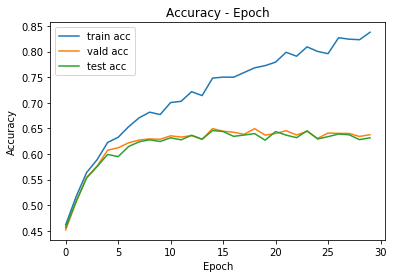

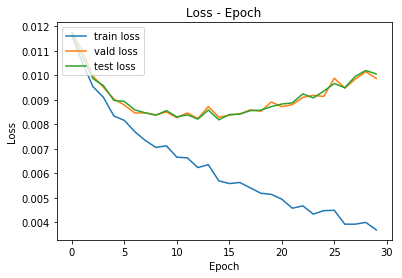

In [9]:
visualize(net, results)

In [10]:
test(net)

Accuracy of the network on the 10000 test images: 63.15%
Accuracy of plane : 71.30%
Accuracy of car   : 74.80%
Accuracy of bird  : 54.50%
Accuracy of cat   : 43.20%
Accuracy of deer  : 59.40%
Accuracy of dog   : 45.30%
Accuracy of frog  : 64.70%
Accuracy of horse : 70.90%
Accuracy of ship  : 77.40%
Accuracy of truck : 70.00%


# Model1

In [11]:
net = model1()

In [12]:
results = train(net)

[Epoch 0 ]: 
train_acc  0.5176 
train_loss 0.015177083129352993 
valid_acc  0.5236 
valid_loss 0.015543995070457459 
test_acc    0.5131 
test_loss  0.0153630353808403
[Epoch 1 ]: 
train_acc  0.6227555555555555 
train_loss 0.014364616211255392 
valid_acc  0.6222 
valid_loss 0.014802601623535156 
test_acc    0.6182 
test_loss  0.014558440136909484
[Epoch 2 ]: 
train_acc  0.6763333333333333 
train_loss 0.013950419563717313 
valid_acc  0.6746 
valid_loss 0.014287819910049439 
test_acc    0.6662 
test_loss  0.014178038704395294
[Epoch 3 ]: 
train_acc  0.7182222222222222 
train_loss 0.013633295051256815 
valid_acc  0.7036 
valid_loss 0.014066540956497193 
test_acc    0.6986 
test_loss  0.01392064243555069
[Epoch 4 ]: 
train_acc  0.7371777777777778 
train_loss 0.013485223582055833 
valid_acc  0.721 
valid_loss 0.013899729919433593 
test_acc    0.7169 
test_loss  0.013787071704864502
[Epoch 5 ]: 
train_acc  0.7773555555555556 
train_loss 0.013176690334743923 
valid_acc  0.7598 
valid_loss 0.01

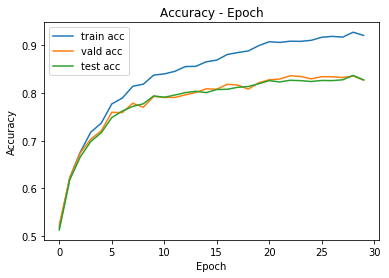

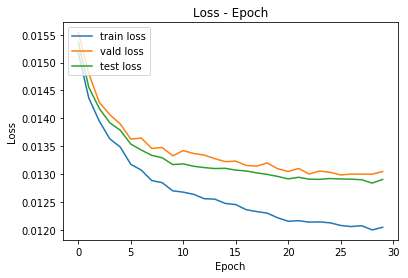

In [13]:
visualize(net, results)

In [14]:
test(net)

Accuracy of the network on the 10000 test images: 82.79%
Accuracy of plane : 90.20%
Accuracy of car   : 90.50%
Accuracy of bird  : 75.40%
Accuracy of cat   : 72.60%
Accuracy of deer  : 78.00%
Accuracy of dog   : 74.20%
Accuracy of frog  : 78.30%
Accuracy of horse : 88.50%
Accuracy of ship  : 86.80%
Accuracy of truck : 93.40%


# Model2

In [15]:
net = model2()

In [16]:
results = train(net)
np.save('report_data/model2_result.npy', results)

[Epoch 0 ]: 
train_acc  0.6231111111111111 
train_loss 0.014479282548692492 
valid_acc  0.6096 
valid_loss 0.014871838712692261 
test_acc    0.6079 
test_loss  0.014727226877212524
[Epoch 1 ]: 
train_acc  0.6907777777777778 
train_loss 0.013914895900090535 
valid_acc  0.6758 
valid_loss 0.014357692050933837 
test_acc    0.6652 
test_loss  0.014232344591617584
[Epoch 2 ]: 
train_acc  0.7360666666666666 
train_loss 0.013543301100201077 
valid_acc  0.7068 
valid_loss 0.014082645797729491 
test_acc    0.6977 
test_loss  0.013968687593936921
[Epoch 3 ]: 
train_acc  0.7551111111111111 
train_loss 0.013379354786872863 
valid_acc  0.7144 
valid_loss 0.01399367754459381 
test_acc    0.7102 
test_loss  0.013869326889514923
[Epoch 4 ]: 
train_acc  0.7703333333333333 
train_loss 0.013249165378676521 
valid_acc  0.7186 
valid_loss 0.013937415337562561 
test_acc    0.7158 
test_loss  0.013803237867355347
[Epoch 5 ]: 
train_acc  0.8044444444444444 
train_loss 0.012990971522861057 
valid_acc  0.744 
v

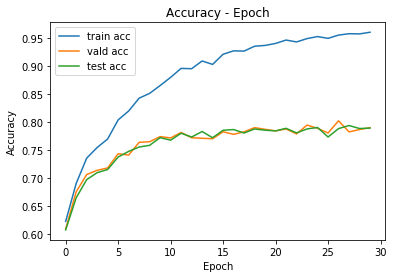

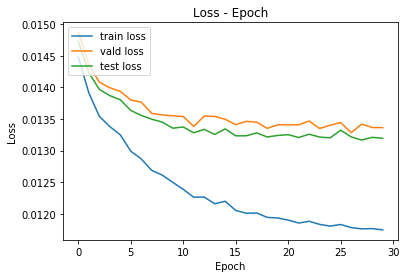

In [17]:
visualize(net, results)

In [18]:
test(net)

Accuracy of the network on the 10000 test images: 78.81%
Accuracy of plane : 83.90%
Accuracy of car   : 90.20%
Accuracy of bird  : 68.20%
Accuracy of cat   : 63.00%
Accuracy of deer  : 78.30%
Accuracy of dog   : 68.20%
Accuracy of frog  : 85.90%
Accuracy of horse : 83.10%
Accuracy of ship  : 85.70%
Accuracy of truck : 82.40%


# Model3

In [19]:
net = model3()

new


In [20]:
results = train(net)
np.save('report_data/model3_result.npy', results)

[Epoch 0 ]: 
train_acc  0.19606666666666667 
train_loss 0.017528268490897284 
valid_acc  0.195 
valid_loss 0.017868266487121583 
test_acc    0.1967 
test_loss  0.017684512519836427
[Epoch 1 ]: 
train_acc  0.25584444444444443 
train_loss 0.017130107100804648 
valid_acc  0.2466 
valid_loss 0.01758383026123047 
test_acc    0.2557 
test_loss  0.01729132194519043
[Epoch 2 ]: 
train_acc  0.26397777777777776 
train_loss 0.017088508886761136 
valid_acc  0.2532 
valid_loss 0.017578517818450927 
test_acc    0.2618 
test_loss  0.017251655101776123
[Epoch 3 ]: 
train_acc  0.2918222222222222 
train_loss 0.01686956732008192 
valid_acc  0.28 
valid_loss 0.017337919473648072 
test_acc    0.2884 
test_loss  0.017059724164009093
[Epoch 4 ]: 
train_acc  0.33237777777777777 
train_loss 0.01658348958492279 
valid_acc  0.3192 
valid_loss 0.017071554803848265 
test_acc    0.3333 
test_loss  0.01673619110584259
[Epoch 5 ]: 
train_acc  0.3492 
train_loss 0.016446105845769245 
valid_acc  0.3466 
valid_loss 0.01

Process Process-839:
Process Process-840:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.5/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.5/multiprocessing/synchronize.py", line 96, i

KeyboardInterrupt: 

In [ ]:
visualize(net, results)

In [ ]:
test(net)

In [ ]:
# enclosed as an function

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(4)))